# Train a Pointcloud classifier in 5 lines of code

> **Skill level:** _Beginner_

Kaolin makes 3D deep learning easy, by providing all the _hard_/_tricky_ parts of coding up a 3D DL application. To get a feel for how easy training classifiers on 3D data has become, here's a quick demo.

In this tutorial, we will train a _pointcloud_ classifier, in about five lines of code!

For those who are new to pointclouds, here's how they look like.

<p align="center">
    <img src="../../assets/airplane_points.png">
</p>

We will use the `ModelNet10` dataset for the remainder of this tutorial. The remainder of this tutorial will be broken down into the following components.

- [Downloading ModelNet10](#downloading-modelnet10)
- [DataLoading](#dataloading)
- [Training the pointcloud classifier](#training-the-pointcloud-classifier)
- [Bells and whistles](#bells-and-whistles)

## Downloading ModelNet10

Note that the ModelNet10 dataset is provided ONLY for the convenience of academic research. Should you choose to download it, you must adhere to the original terms and copyright notice of the dataset. For convenience, we reproduce the original copyright from the dataset creators.

```
**Copyright**

All CAD models are downloaded from the Internet and the original authors hold the copyright of the CAD models. The label of the data was obtained by us via Amazon Mechanical Turk service and it is provided freely. This dataset is provided for the convenience of academic research only.
```

The ModelNet10 (10-class subset) dataset is available on the [Princeton ModelNet page](https://modelnet.cs.princeton.edu/). On this page, navigate to the ModelNet10 download link to obtain the dataset. We assume that it is unzipped and extracted to a location `MODELNET_DIRECTORY`.

## Warm-up

Before all the fun-stuff begins, let us import all necessary functions from `kaolin` and `torch`. A bit more on what the following modules do will become clear as we progress.

In [1]:
import torch
from torch.utils.data import DataLoader
import kaolin as kal
from kaolin import ClassificationEngine
from kaolin.datasets import ModelNet
from kaolin.models.PointNet import PointNetClassifier as PointNet
import kaolin.transforms as tfs

## Dataloading

Kaolin provides convenience functions to load popular 3D datasets (of course, ModelNet10). Assuming you have [installed Kaolin](../../README.md#installation-and-usage), fire up your favourite python interpreter, and execute the following commands.

To start, we will define a few important parameters:

In [7]:
modelnet_path = 'path/to/ModelNet10/'
categories = ['chair', 'sofa']
num_points = 1024
device = 'cuda'

The `model_path` variable will hold the path to the ModelNet10 dataset. We will use the `categories` variable to specify which classes we want to learn to classify. `num_points` is the number of points we will sample from the mesh when transforming it to a pointcloud. Finally, we will use `device = 'cuda'` to tell pytorch to run everything on the GPU.

In [8]:
transform = tfs.Compose([
    tfs.TriangleMeshToPointCloud(num_samples=num_points),
    tfs.NormalizePointCloud()
])

This command defines a `transform` that first converts a mesh representation to a pointcloud and then _normalizes_ it to be centered at the origin, and have a standard deviation of 1. Much like images, 3D data such as pointclouds need to be normalized for better classification performance.

In [9]:
train_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                   split='train', transform=transform, device=device),
                          batch_size=12, shuffle=True)

Phew, that was slightly long! But here's what it does. It creates a `DataLoader` object for the `ModelNet10` dataset. In particular, we are interested in loading only the `chair` and `sofa` categories. The `split='train'` argument indicates that we're loading the 'train' split. The `rep='pointcloud'` loads up meshes and converts them into pointclouds. The `transform=norm` applies a normalizing transform to each pointcloud. The other parameters are fairly easy to decipher.

Similarly, the test dataset can be loaded up as follows.

In [10]:
val_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                 split='test',transform=transform, device=device),
                        batch_size=12)

## Training the pointcloud classifier

Now that all of the data is ready, we can train our classifier using the `ClassificationEngine` class provided by Kaolin. The following line of code will train and validate a _PointNet_ classifier, which is probably the simplest of pointcloud neural architectures.

In [12]:
engine = ClassificationEngine(PointNet(num_classes=len(categories)), train_loader, val_loader, device=device)
engine.fit()

Epoch: 0, Train loss: 0.6694982051849365, Train accuracy: 0.5
Epoch: 0, Train loss: 0.5653945654630661, Train accuracy: 0.5833333432674408
Epoch: 0, Train loss: 0.5014831225077311, Train accuracy: 0.6666666865348816
Epoch: 0, Train loss: 0.49184250086545944, Train accuracy: 0.708333358168602
Epoch: 0, Train loss: 0.5620267212390899, Train accuracy: 0.7000000238418579
Epoch: 0, Train loss: 0.500747894247373, Train accuracy: 0.750000019868215
Epoch: 0, Train loss: 0.4492198143686567, Train accuracy: 0.7738095436777387
Epoch: 0, Train loss: 0.4623255431652069, Train accuracy: 0.7916666865348816
...
Epoch: 9, Val loss: 0.0035466860532654787, Val accuracy: 1.0
Epoch: 9, Val loss: 0.0032632484932643515, Val accuracy: 1.0
Epoch: 9, Val loss: 0.0030263021874886295, Val accuracy: 1.0
Epoch: 9, Val loss: 0.0030067365649821503, Val accuracy: 1.0
Epoch: 9, Val loss: 0.002820616417254011, Val accuracy: 1.0
Epoch: 9, Val loss: 0.0027499566349433735, Val accuracy: 1.0
Epoch: 9, Val loss: 0.0026160070

## Visualizing the results

We will create a new dataloder which will load the same data as our previous val_loader but with shuffling, and take a sample batch.

In [14]:
test_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                 split='test',transform=transform, device=device),
                        shuffle=True, batch_size=15)

test_batch, labels = next(iter(test_loader))
preds = engine.model(test_batch)
pred_labels = torch.max(preds, axis=1)[1]

Next, we setup a plot to visualize the pointcloud, groundtruth label and our prediction using a small utility function. Here we've also colour-coded the results - green for correct and red for incorrect.

<IPython.core.display.Javascript object>


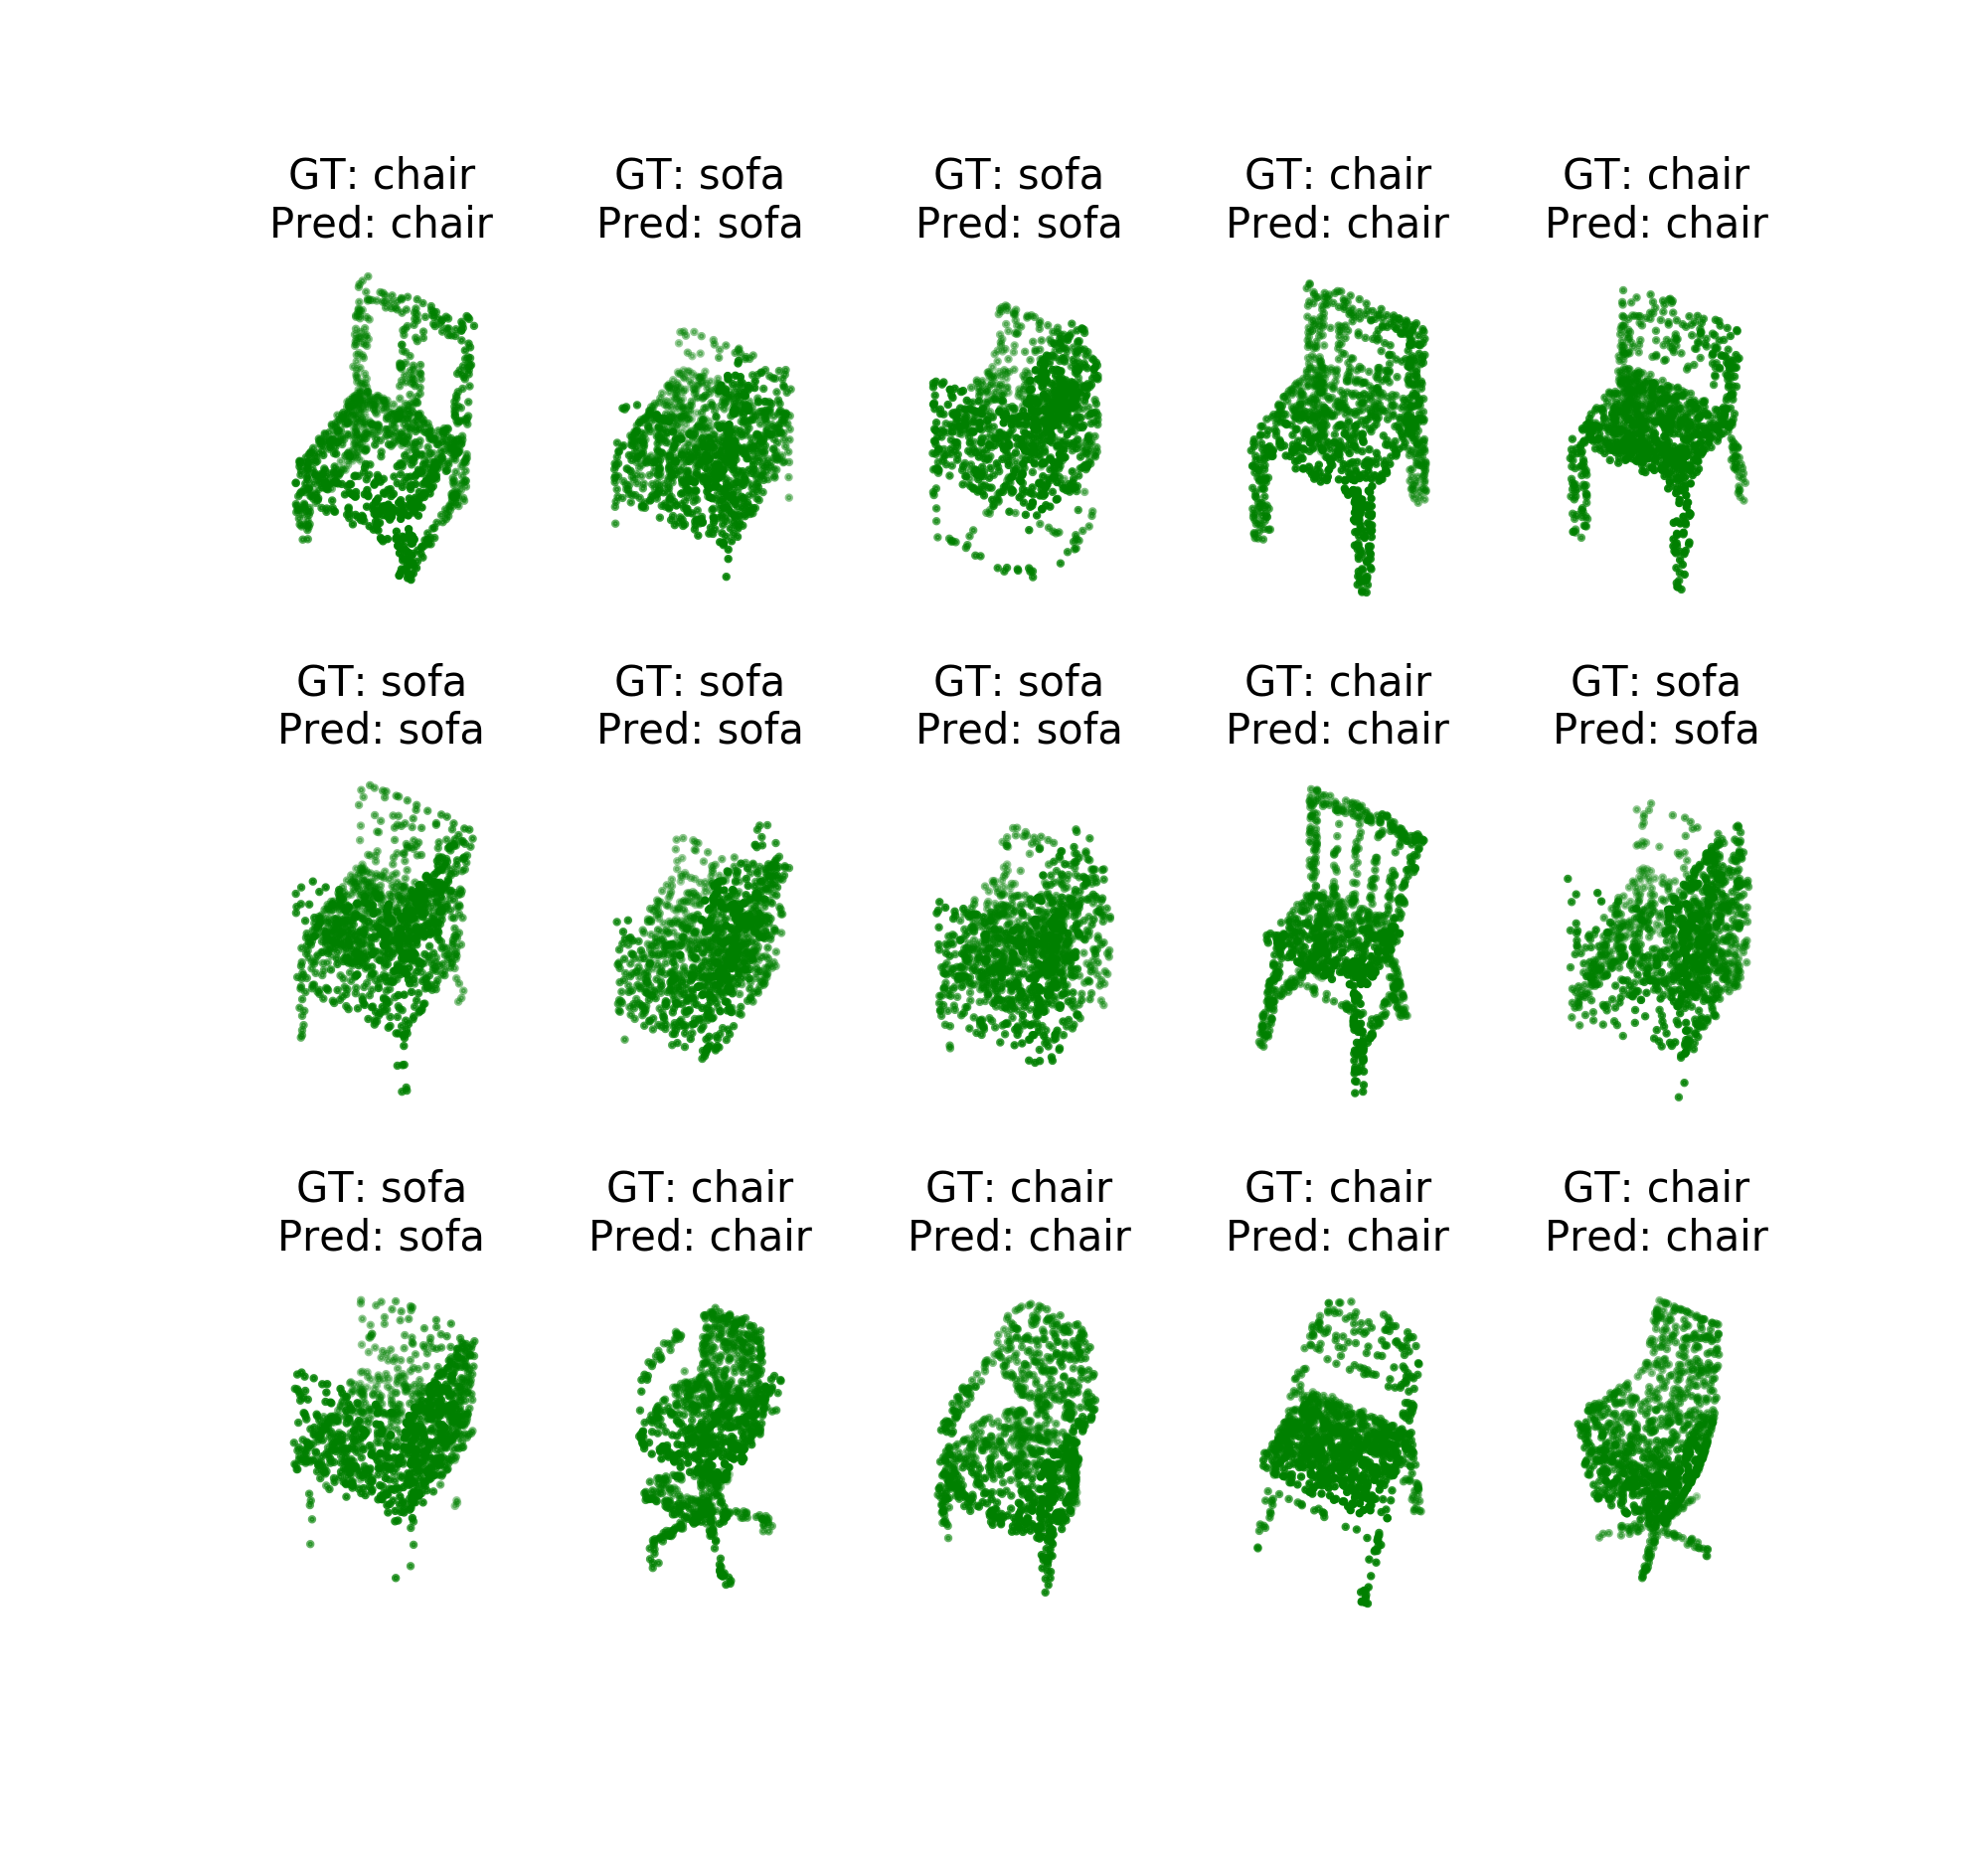

In [25]:
from utils import visualize_batch

%matplotlib notebook

visualize_batch(test_batch, pred_labels, labels, categories)

Looks like everything is green!

That's it, you've trained your first 3D classifier on pointcloud data using Kaolin!! Read through to find out more bells-and-whistles about the `ClassificationEngine` and how you can configure it.

The code is available in `pointcloud_classification_engine.py`.

For a more explicit example without the `ClassificationEngine` class, please see the code in `pointcloud_classification.py`


## Bells and whistles

The `ClassificationEngine` can be customized to suit your needs.

You can train on other categories by simply changing the `categories` argument passed to the `ModelNet10` dataset object. For example, you can add a `bed` class by running
```python
dataset = ModelNet('/path/to/ModelNet10', categories=['chair', 'sofa', 'bed'],
                   split='train', rep='pointcloud', transform=norm, device='cuda:0')
```

You can also configure the parameters of the `PointNet` to your liking. For a more detailed explanation, refer to the documentation of the `PointNetClassifier` class.

Further, you can pass several parameters that configure the learning rate, optimizer, training duration, and more. A detailed description can be accessed from the documentation for the `ClassificationEngine` class.
